https://github.com/Toblerity/Fiona/issues/944

In [67]:
import fiona

In [68]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas

In [69]:
import maup
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges, exterior_boundaries, exterior_boundaries_as_a_set
from networkx import is_connected, connected_components


In [70]:
graph = Graph.from_file("./az_precincts.zip", ignore_errors=True)
precincts = geopandas.read_file("./az_precincts.zip")

C:\Users\darre\anaconda3\envs\gerrychain\lib\site-packages\gerrychain\graph\adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(153, 617), (61, 235), (224, 241), (991, 1081), (101, 1482), (354, 637), (554, 1089), (715, 768), (1034, 1388), (27, 132), (860, 1281), (533, 767), (119, 215), (36, 89), (88, 127), (82, 175), (106, 532), (410, 516), (578, 637), (118, 524), (615, 1330), (39, 1292), (143, 318), (140, 420), (331, 1400), (76, 127), (372, 672), (421, 1431), (19, 377), (66, 974), (134, 343), (329, 710), (380, 532), (799, 1400), (307, 389), (608, 1430), (102, 377), (54, 1112), (48, 177), (66, 848), (39, 1379), (555, 1024), (84, 246), (1201, 1434), (291, 447), (1208, 1412), (1377, 1388), (503, 723), (421, 651), (1053, 1383), (300, 352), (433, 1400), (1252, 1363), (185, 285), (676, 1316), (39, 1372), (340, 406), (427, 1487), (991, 1181), (42, 212), (488, 1482), (29, 669), (81, 978), (444, 1039), (451, 1481), (647, 1246), (727, 1126), (351, 439),

In [71]:
components = list(connected_components(graph))
biggest_component_size = max(len(c) for c in components)
problem_components = [c for c in components if len(c) != biggest_component_size]
for component in problem_components:
    for node in component:
        graph.remove_node(node)
is_connected(graph)

True

In [72]:
election = Election("PRES16", {"Dem": "PRES16D", "Rep": "PRES16R"})

initial_partition = GeographicPartition(
    graph,
    assignment="CD",
    updaters={
        "cut_edges": cut_edges,
        "population": Tally("TOTPOP", alias="population"),
        "PRES16": election
    }
)

In [73]:
from gerrychain.constraints.contiguity import contiguous_components, contiguous
from gerrychain import Partition
bad_nodeview = contiguous_components(initial_partition).get('01')[1].nodes()
bad_nodeview

NodeView((208,))

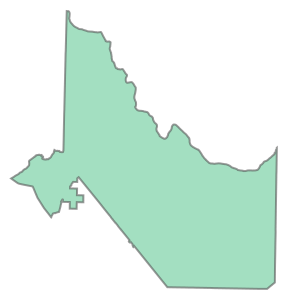

In [74]:
graph.geometry[208]

In [75]:
graph

<Graph [1489 nodes, 4096 edges]>

In [76]:
contiguous_components(initial_partition)

{'01': [<Graph [278 nodes, 723 edges]>, <Graph [1 nodes, 0 edges]>],
 '03': [<Graph [178 nodes, 409 edges]>],
 '07': [<Graph [107 nodes, 245 edges]>],
 '05': [<Graph [128 nodes, 310 edges]>],
 '04': [<Graph [162 nodes, 381 edges]>],
 '02': [<Graph [195 nodes, 497 edges]>],
 '09': [<Graph [140 nodes, 310 edges]>],
 '06': [<Graph [157 nodes, 396 edges]>],
 '08': [<Graph [143 nodes, 371 edges]>]}

Arizona has some missing edges in its graph

In [77]:
graph.add_edge(208,378)
graph.add_edge(208,202)
graph.add_edge(208,780)
graph.add_edge(208,90)
graph.add_edge(208,42)

In [78]:
graph

<Graph [1489 nodes, 4097 edges]>

Recreate the initial partition

In [79]:
contiguous_components(initial_partition)

{'01': [<Graph [279 nodes, 724 edges]>],
 '03': [<Graph [178 nodes, 409 edges]>],
 '07': [<Graph [107 nodes, 245 edges]>],
 '05': [<Graph [128 nodes, 310 edges]>],
 '04': [<Graph [162 nodes, 381 edges]>],
 '02': [<Graph [195 nodes, 497 edges]>],
 '09': [<Graph [140 nodes, 310 edges]>],
 '06': [<Graph [157 nodes, 396 edges]>],
 '08': [<Graph [143 nodes, 371 edges]>]}

In [80]:
election = Election("PRES16", {"Dem": "PRES16D", "Rep": "PRES16R"})

initial_partition = GeographicPartition(
    graph,
    assignment="CD",
    updaters={
        "cut_edges": cut_edges,
        "population": Tally("TOTPOP", alias="population"),
        "PRES16": election
    }
)

In [81]:
for district, pop in initial_partition["population"].items():
    print("District {}: {}".format(district, pop))

District 01: 710176.0
District 03: 710252.0
District 07: 710220.0
District 05: 710224.0
District 04: 710224.0
District 02: 710244.0
District 09: 710224.0
District 06: 710221.0
District 08: 710232.0


In [82]:
sum_population = sum(initial_partition["population"].values())
ideal_population = sum_population / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=.9,
                   node_repeats=2
                  )

In [83]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, .02)

In [86]:
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous, contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
steps = 500
chain = MarkovChain(
    proposal=proposal,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=steps
)

In [85]:
last1 = None
for partition in chain.with_progress_bar():
    last1 = partition

  2%|▏         | 24/1000 [42:35<28:52:23, 106.50s/it]


KeyboardInterrupt: 

In [ ]:
last1.plot(figsize=(10, 10), cmap="tab20")
plt.axis('off')
plt.show()

In [ ]:
last1

In [ ]:
initial_partition2 = GeographicPartition(
    graph,
    assignment="CD",
    updaters={
        "cut_edges": cut_edges,
        "population": Tally("TOTPOP", alias="population"),
        "PRES16": election
    }
)
initial_partition2.assignment = last1.assignment
initial_partition2.subgraphs = last1.subgraphs

In [ ]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=.02,
                   node_repeats=2
                  )

In [ ]:
steps = 500
chain = MarkovChain(
    proposal=proposal,
    constraints=[single_flip_contiguous, compactness_bound],
    accept=always_accept,
    initial_state=initial_partition2,
    total_steps=steps
)

In [ ]:
last2 = None
for partition in chain.with_progress_bar():
    last2 = partition

In [ ]:
last2.plot(figsize=(10, 10), cmap="tab20")
plt.axis('off')
plt.show()